In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';    
    
        var cells = IPython.notebook.get_cells();    
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import gridspec
from matplotlib import colors

import os
import re
import numpy as np
import pandas as pd
import cooler

import itertools

import seaborn as sns

In [4]:
# cooltools used dekkerlab-fork, develop-branch, commit-af508bba9c6577b8271b716ba27c330bead15981
from cooler.tools import split, partition
from functools import partial
from cooltools import expected

import bioframe
from bioframe.io import resources
from bioframe import io

from cooltools import numutils
from cooltools.eigdecomp import cooler_cis_eig

In [5]:
from helper_module import fillcolor_compartment_style, to_uscs, bar_signal, random_test

In [6]:
from matplotlib import ticker
mb_format = ticker.FuncFormatter(lambda bp, pos: f"{int(bp/1_000_000)}")

In [7]:
cooler_names = [
    'all-allele-spe-2percent-highcis.galGal5.mapq_30.1000.mcool',
#     'all-allele-spe-1percent-highcis.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-1-3-16-2p-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
#     'MNP-DT40-1-3-16-R2-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-1-3-17-2p-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
#     'MNP-DT40-1-3-17-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-WT1-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-WT2-R1-T1__galGal5.galGal5.mapq_30.1000.mcool']

### generate some nicer sample names from coolers ...

In [8]:
# multiqc learnings here, btw!...
renamings = {"all-allele-spe":"pool",
            ".galGal5.mapq_30.1000.mcool":"",
            "MNP-DT40-":"",
            "-T1__galGal5":"",
            "-R1":"",
            "1-3-":"clone-"}

sample_names = []
for c in cooler_names:
    for rf,rt in renamings.items():
        c = re.sub(rf,rt,c)
    sample_names.append(c)

# sample_names

# form a df of samples here:
samples = pd.DataFrame({"sample":sample_names,"mcool":cooler_names})

samples

,sample,mcool
0,pool-2percent-highcis,all-allele-spe-2percent-highcis.galGal5.mapq_3...
1,clone-16-2p,MNP-DT40-1-3-16-2p-R1-T1__galGal5.galGal5.mapq...
2,clone-17-2p,MNP-DT40-1-3-17-2p-R1-T1__galGal5.galGal5.mapq...
3,WT1,MNP-DT40-WT1-R1-T1__galGal5.galGal5.mapq_30.10...
4,WT2,MNP-DT40-WT2-R1-T1__galGal5.galGal5.mapq_30.10...


### read some coolers and extract raw number of interactions between allele1/2 and other chromosomes ...

In [9]:
# READ SOME COOLERS ...
# oldref-20200617
cool_path = "/home/venevs/DOTS_TESTING/alv-chicken/oldref-20200617"
get_cpath = lambda c,b: os.path.join(cool_path,c+f"::/resolutions/{b}")

insertion_site = 72_500_000

dfs = {}
for s in samples["sample"]:
    if "WT" not in s:
        _bsize = 1_000_000
        s_cname, = samples["mcool"][samples["sample"]==s]
        _c = cooler.Cooler(get_cpath(s_cname,_bsize))
        _df = pd.DataFrame(_c.chromsizes).reset_index().rename({"name":"chrom"},axis=1)
        a1_idx = _c.offset("allele1")
        a2_idx = _c.offset("allele2")
        chr1_idx = slice(*_c.extent("chr1"))
        # chr1_idx = _c.offset(("chr1",insertion_site,insertion_site+_bsize))
        _df["allele1"] = [np.sum(_c.matrix(balance=False)[a1_idx,slice(*_c.extent(chrom))]) for chrom in _c.chromnames]
        _df["allele2"] = [np.sum(_c.matrix(balance=False)[a2_idx,slice(*_c.extent(chrom))]) for chrom in _c.chromnames]
        _df["chr1"] = [np.sum(_c.matrix(balance=False)[chr1_idx,slice(*_c.extent(chrom))]) for chrom in _c.chromnames]
        dfs[s] = _df

### now let's compare number of interactions per bp betweeb allele1/2

/home/venevs/miniconda3/envs/newexp/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/venevs/miniconda3/envs/newexp/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


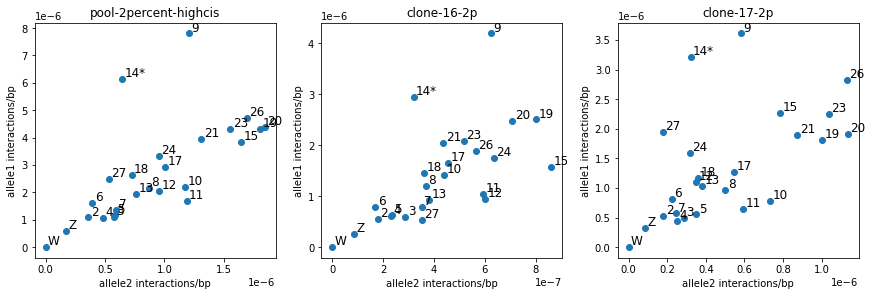

In [10]:

fx = plt.figure(figsize=(12,4),constrained_layout=True)

spx = fx.add_gridspec(
                ncols=3,
                nrows=1,
                width_ratios=[1,1,1],
            )
ax = [0]*3
for i in range(3):
    ax[i] = fx.add_subplot(spx[i])
# ax2 = fx.add_subplot(spx[1])#,sharey=ax1)


idx = 0
for s in samples["sample"]:
    if "WT" not in s:
        dd = dfs[s]
        al1_total = dd["allele1"].sum()
        al2_total = dd["allele2"].sum()
        # pre-filter dd (by length or whatever)
        cond1 = dd["length"] >= 5_000_000
        cond2 = ~dd["chrom"].isin(["allele1","allele2","chr1"])
        dd = dd[ cond1 & cond2 ]
        #
        # normalize # of contacts and plot ...
        dd["allele1_rel"] = dd["allele1"]/dd["length"]#/al1_sum
        dd["allele2_rel"] = dd["allele2"]/dd["length"]#/al2_sum
        #
        x=dd["allele2_rel"].values
        y=dd["allele1_rel"].values
        ax[idx].scatter(x=dd["allele2_rel"].values,y=dd["allele1_rel"].values)            
        for i, txt in enumerate(dd["chrom"].values):
            dx, = np.diff(ax[idx].get_xlim())
            dy, = np.diff(ax[idx].get_ylim())
            dx *= 0.01
            dy *= 0.01
            if txt == "chr14":
                txt = "chr14*"
            ax[idx].annotate(txt.lstrip("chr"), (x[i]+dx, y[i]+dy),fontsize=12)
        #
        ax[idx].set_title(s)
        ax[idx].set_xlabel("allele2 interactions/bp")
        ax[idx].set_ylabel("allele1 interactions/bp")
        idx += 1

        
        
# plt.savefig("trans_scatter.pdf")

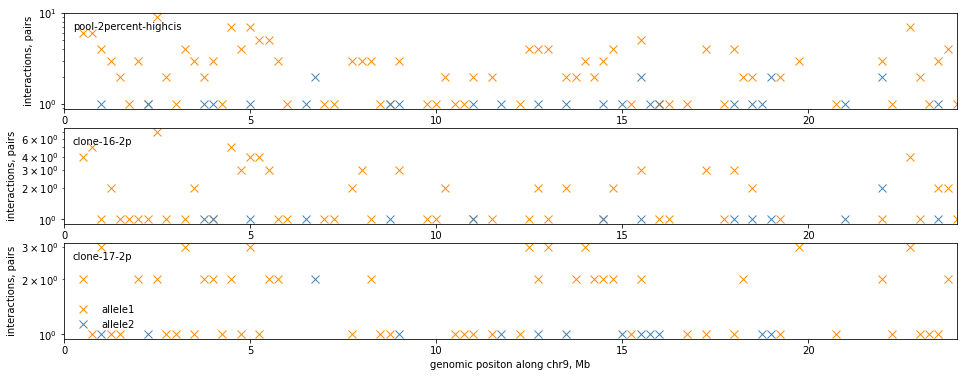

In [14]:
chrom="chr9"
f = plt.figure(figsize=(16,6))
sp = f.add_gridspec(ncols=1,nrows=3)
_bsize = 250_000
balanced = False
for i in range(3):
    ax = f.add_subplot(sp[i])
    s = samples["sample"][i]
    s_cname, = samples["mcool"][samples["sample"]==s]
    clr = cooler.Cooler(get_cpath(s_cname,_bsize))

    a1_idx = clr.offset("allele1")
    a2_idx = clr.offset("allele2")
    chr_idx = slice(*clr.extent(chrom))

    al1_chr, = clr.matrix(balance=balanced)[a1_idx,chr_idx]
    al2_chr, = clr.matrix(balance=balanced)[a2_idx,chr_idx]

    x = clr.bins()[chr_idx]["start"].values
    
    al1_vis = dict(color="darkorange", marker='x', markersize=8, linewidth=0, label="allele1", alpha=0.999)
    al2_vis = dict(color='steelblue', marker='x', markersize=8, linewidth=0, label="allele2", alpha=0.999)

    plt.plot(x, al1_chr, **al1_vis)
    plt.plot(x, al2_chr, **al2_vis)
    plt.gca().set_yscale("log")
    ax = plt.gca()
    ax.set_xlim(x.min(),x.max())
    ax.xaxis.set_major_formatter(mb_format)
    ax.set_ylabel("interactions, pairs")
    ax.text(0.01,0.82,s,transform=ax.transAxes)

ax.set_xlabel(f"genomic positon along {chrom}, Mb")
plt.legend(frameon=False)
# plt.savefig("supp-raw-overview-chr14.pdf")